# NanoEvents tutorial

This is a rendered copy of [nanoevents.ipynb](https://github.com/CoffeaTeam/coffea/blob/master/binder/nanoevents.ipynb). You can optionally run it interactively on [binder at this link](https://mybinder.org/v2/gh/coffeateam/coffea/master?filepath=binder%2Fnanoevents.ipynb)

NanoEvents is a Coffea utility to wrap flat nTuple structures (such as the CMS [NanoAOD](https://www.epj-conferences.org/articles/epjconf/pdf/2019/19/epjconf_chep2018_06021.pdf) format) into a single awkward array with appropriate object methods (such as [Lorentz vector methods](https://coffeateam.github.io/coffea/modules/coffea.nanoevents.methods.vector.html)), cross references, and nested objects, all lazily accessed from the source ROOT TTree via uproot. The interpretation of the TTree data is configurable via schema objects, which are community-supplied interpretations for various source file types. These schema objects allow a richer interpretation of the file contents than the [uproot.lazy](https://uproot4.readthedocs.io/en/latest/uproot4.behaviors.TBranch.lazy.html) method.

In this demo, we will use NanoEvents to read a small CMS NanoAOD sample. The events object can be instantiated as follows:

In [1]:
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

fname = "https://raw.githubusercontent.com/CoffeaTeam/coffea/master/tests/samples/nano_dy.root"
events = NanoEventsFactory.from_root(fname, schemaclass=NanoAODSchema).events()

Consider looking at the [from_file](https://coffeateam.github.io/coffea/api/coffea.nanoevents.NanoEventsFactory.html#coffea.nanoevents.NanoEventsFactory.from_file) class method to see the optional arguments.

The `events` object is an awkward array, which at its top level is a record array with one record for each "collection", where a collection is a grouping of fields (TBranches) based on the naming conventions of [NanoAODSchema](https://coffeateam.github.io/coffea/api/coffea.nanoevents.NanoAODSchema.html). For example, in the file we opened, the branches:
```
Generator_binvar
Generator_scalePDF
Generator_weight
Generator_x1
Generator_x2
Generator_xpdf1
Generator_xpdf2
Generator_id1
Generator_id2
```
are grouped into one sub-record named `Generator` which can be accessed using either getitem or getattr syntax, i.e. `events["Generator"]` or `events.Generator`. e.g.

In [2]:
events.Generator.id1

<Array [1, -1, -1, 21, 21, ... 2, -2, -1, 2, 1] type='40 * int32[parameters={"__...'>

In [3]:
# all names can be listed with:
events.Generator.fields

['binvar', 'id1', 'id2', 'scalePDF', 'weight', 'x1', 'x2', 'xpdf1', 'xpdf2']

In CMS NanoAOD, each TBranch has a help string, which is carried into the NanoEvents, e.g. executing the following cell should produce a help pop-up:
```
Type:            Array
String form:     [1, -1, -1, 21, 21, 4, 2, -2, 2, 1, 3, 1, ... -1, -1, 1, -2, 2, 1, 2, -2, -1, 2, 1]
Length:          40
File:            ~/src/awkward-1.0/awkward1/highlevel.py
Docstring:       id of first parton
Class docstring: ...
```
where the `Docstring` shows information about the content of this array.

In [4]:
events.Generator.id1?

Based on a collection's name or contents, some collections acquire additional _methods_, which are extra features exposed by the code in the mixin classes of the `coffea.nanoevents.methods` modules. For example, although `events.GenJet` has the fields:

In [5]:
events.GenJet.fields

['eta', 'mass', 'phi', 'pt', 'partonFlavour', 'hadronFlavour']

we can access additional attributes associated to each generated jet by virtue of the fact that they can be interpreted as [Lorentz vectors](https://coffeateam.github.io/coffea/api/coffea.nanoevents.methods.vector.LorentzVector.html#coffea.nanoevents.methods.vector.LorentzVector):

In [6]:
events.GenJet.energy

<Array [[217, 670, 258], ... 16], [76.9]] type='40 * var * float32'>

We can call more complex methods, like computing the distance $\Delta R = \sqrt{\Delta \eta^2 + \Delta \phi ^2}$ between two LorentzVector objects:

In [7]:
# find distance between leading jet and all electrons in each event
dr = events.Jet[:, 0].delta_r(events.Electron)
dr

<Array [[], [3.13], [3.45, ... 0.0858], [], []] type='40 * var * float32'>

In [8]:
# find minimum distance
ak.min(dr, axis=1)

<Array [None, 3.13, 2.18, ... None, None] type='40 * ?float32'>

The assignment of methods classes to collections is done inside the schema object during the initial creation of the array, governed by the awkward array's `__record__` parameter and the associated behavior. See [ak.behavior](https://awkward-array.readthedocs.io/en/latest/ak.behavior.html) for a more detailed explanation of array behaviors.

Additional methods provide convenience functions for interpreting some branches, e.g. CMS NanoAOD packs several jet identification flag bits into a single integer, `jetId`. By implementing the bit-twiddling in the [Jet mixin](https://github.com/CoffeaTeam/coffea/blob/7045c06b9448d2be4315e65d432e6d8bd117d6d7/coffea/nanoevents/methods/nanoaod.py#L279-L282), the analsyis code becomes more clear:

In [9]:
print(events.Jet.jetId)
print(events.Jet.isTight)

[[6, 6, 6, 6, 6], [6, 2, 6, 6, 6, 6, 6, 0], ... 6], [6], [6, 6, 0, 6, 6, 6], [6, 6]]
[[True, True, True, True, True], [True, ... False, True, True, True], [True, True]]


We can also define convenience functions to unpack and apply some mask to a set of flags, e.g. for generated particles:

In [10]:
print(f"Raw status flags: {events.GenPart.statusFlags}")
events.GenPart.hasFlags(['isPrompt', 'isLastCopy'])

Raw status flags: [[10625, 27009, 4481, 22913, 257, 257, ... 13884, 13884, 12876, 12876, 12876, 12876]]


<Array [[True, True, False, ... False, False]] type='40 * var * bool'>

CMS NanoAOD also contains pre-computed cross-references for some types of collections. For example, there is a TBranch `Electron_genPartIdx` which indexes the `GenPart` collection per event to give the matched generated particle, and `-1` if no match is found. NanoEvents transforms these indices into an awkward _indexed array_ pointing to the collection, so that one can directly access the matched particle using getattr syntax:

In [11]:
events.Electron.matched_gen.pdgId

<Array [[], [-11], [-11, ... [None], [], []] type='40 * var * ?int32[parameters=...'>

In [12]:
events.Muon.matched_jet.pt

<Array [[], [], [], [], ... [], [], [], []] type='40 * var * ?float32[parameters...'>

For generated particles, the parent index is similarly mapped:

In [13]:
events.GenPart.parent.pdgId

<Array [[None, None, 1, 1, ... 111, 111, 111]] type='40 * var * ?int32[parameter...'>

In addition, using the parent index, a helper method computes the inverse mapping, namely, `children`. As such, one can find particle siblings with:

In [14]:
events.GenPart.parent.children.pdgId
# notice this is a doubly-jagged array

/Users/lagray/miniconda3/envs/coffea-work/lib/python3.7/site-packages/numba/core/dispatcher.py:238: UserWarning: Numba extension module 'awkward1._connect._numba' failed to load due to 'ImportError(generic_type: type "kernel_lib" is already registered!)'.
  entrypoints.init_all()


<Array [[None, None, [23, 21, ... [22, 22]]] type='40 * var * option[var * ?int3...'>

Since often one wants to shortcut repeated particles in a decay sequence, a helper method `distinctParent` is also available. Here we use it to find the parent particle ID for all prompt electrons:

In [15]:
events.GenPart[
    (abs(events.GenPart.pdgId) == 11)
    & events.GenPart.hasFlags(['isPrompt', 'isLastCopy'])
].distinctParent.pdgId

<Array [[], [23, 23], [23, ... [23, 23], []] type='40 * var * ?int32[parameters=...'>

Events can be filtered like any other awkward array using boolean fancy-indexing

In [16]:
mmevents = events[ak.num(events.Muon) == 2]
zmm = mmevents.Muon[:, 0] + mmevents.Muon[:, 1]
zmm.mass

<Array [94.6, 87.6, 88, 90.4, 89.1, 31.6] type='6 * float32'>

One can assign new variables to the arrays, with some caveats:

 * Assignment must use setitem (`events["path", "to", "name"] = value`)
 * Assignment to a sliced `events` won't be accessible from the original variable
 * New variables are not visible from cross-references

In [17]:
mmevents["Electron", "myvar2"] = mmevents.Electron.pt + zmm.mass
mmevents.Electron.myvar2

<Array [[], [121], [], [], [], []] type='6 * var * float32'>

## Using NanoEvents with a processor

NanoEvents can also be used inside a coffea [processor](https://coffeateam.github.io/coffea/api/coffea.processor.ProcessorABC.html#coffea.processor.ProcessorABC), as shown in this simple Z peak sketch below. To use NanoEvents with `run_uproot_job`, pass the appropriate schema as an executor argument, e.g. `"schema": NanoAODSchema` for this example. The dataset name is included in the `events` object under the `metadata` attribute.

In [18]:
from coffea import processor, hist

class MyZPeak(processor.ProcessorABC):
    def __init__(self):
        self._histo = hist.Hist(
            "Events",
            hist.Cat("dataset", "Dataset"),
            hist.Bin("mass", "Z mass", 60, 60, 120),
        )
    
    @property
    def accumulator(self):
        return self._histo
    
    # we will receive a NanoEvents instead of a coffea DataFrame
    def process(self, events):
        out = self.accumulator.identity()
        mmevents = events[
            (ak.num(events.Muon) == 2)
            & (ak.sum(events.Muon.charge, axis=1) == 0)
        ]
        zmm = mmevents.Muon[:, 0] + mmevents.Muon[:, 1]
        out.fill(
            dataset=events.metadata["dataset"],
            mass=zmm.mass,
        )
        return out
    
    def postprocess(self, accumulator):
        return accumulator

In [19]:
samples = {
    "DrellYan": [fname]
}

result = processor.run_uproot_job(
    samples,
    "Events",
    MyZPeak(),
    processor.iterative_executor,
    {"schema": NanoAODSchema},
)

<AxesSubplot:xlabel='Z mass', ylabel='Events'>

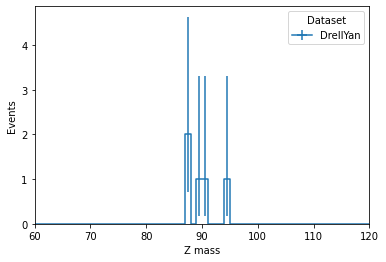

In [20]:
%matplotlib inline

hist.plot1d(result)